
Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [x] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [x] Make at least 1 partial dependence plot to explain your model.
- [x] Make at least 1 Shapley force plot to explain an individual prediction.
- [x] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [27]:
import pandas as pd
from pathlib import Path

filepath = Path('../data/steam/steam.csv')
data = pd.read_csv(filepath)

import math
import numpy as np


def create_target(data:pd.DataFrame):
    data = data.copy()
    df = data[['positive_ratings', 'negative_ratings']]
    data = data.drop(['positive_ratings', 'negative_ratings'], axis=1)
    df['total_reviews'] = df['positive_ratings'] + df['negative_ratings']
    df =df[df['total_reviews'] >= 500]
    df['review_score'] = df['positive_ratings'] / df['total_reviews']
    df['superscript']= [math.log10(x+1) for x in df['total_reviews']]
    df['exponent'] = [2**(-x) for x in df['superscript']]
    df['rating'] =  [x-(x-0.5) * y for x,y in zip(df['review_score'], df['exponent'])]
    df['good'] = df['rating'] >= 0.80
    data = data.merge(df[['good']], left_index=True,right_index=True)
    genres = data['genres'].str.split(';', expand=True).stack().str.get_dummies().add_prefix('genre_').sum(level=0)
    tags = data['steamspy_tags'].str.split(';', expand=True).stack().str.get_dummies().add_prefix('tag_').sum(level=0)
    categories = data['categories'].str.split(';', expand=True).stack().str.get_dummies().add_prefix('category_').sum(level=0)
    platforms = data['platforms'].str.split(';', expand=True).stack().str.get_dummies().add_prefix('platform_').sum(level=0)
    data = data.merge(genres, left_index=True, right_index=True)
    data = data.merge(tags, left_index=True, right_index=True)
    data = data.merge(categories, left_index=True, right_index=True)
    data = data.merge(platforms, left_index=True, right_index=True)
    return data

data_with_target = create_target(data)


def x_y_split(df):
    target = 'good'
    X = df.copy().drop(target, axis=1)
    y = df.copy()[target]
    return X, y

from sklearn.model_selection import train_test_split
train_and_val_set, test_set = train_test_split(data_with_target, stratify = data_with_target['good'], random_state = 11)
train_set, val_set = train_test_split(train_and_val_set, stratify = train_and_val_set['good'], random_state = 11)

X_train, y_train = x_y_split(train_set)
X_val, y_val = x_y_split(val_set)
X_test, y_test = x_y_split(test_set)

train = (X_train, y_train)
val = (X_val, y_val)
test = (X_test, y_test)

from lightgbm import LGBMClassifier

from sklearn.base import TransformerMixin
import category_encoders as ce
import numpy as np


class Wrangler(TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X):
        X = X.copy()
        cols_with_zeros = ['average_playtime', 'median_playtime']
        for col in cols_with_zeros:
            X[col] = X[col].replace(0, np.nan)
        X['release_date'] = pd.to_datetime(X['release_date'], infer_datetime_format=True)
        X['year'] = X['release_date'].dt.year
        X['month'] = X['release_date'].dt.month
        X['day'] = X['release_date'].dt.day
        X['owners'] =[(int(a) + int(b)) /2 for a, b in [x.split('-') for x in X['owners']]]
        X['revenue'] = X['owners'] * X['price']
        X['man_hours_playtime'] = X ['owners'] * X['median_playtime']
        X = X.drop(columns=[ 'appid', 'name', 'release_date', 'genres', 'steamspy_tags', 'name', 'categories', 'platforms'])

        return X


class NumericalFilter(TransformerMixin):

    def __init__(self, include = True):
        self.columns = None
        self.include = include

    def fit(self, X, y=None,**fit_params):
        if self.include:
            self.columns = X.select_dtypes(include='number').columns.tolist()
        else:
            self.columns = X.select_dtypes(exclude='number').columns.tolist()
        return self

    def transform(self, X):
        return X[self.columns]

In [4]:
from sklearn.pipeline import make_pipeline, make_union
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import lightgbm
from lightgbm import LGBMClassifier
import numpy as np
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

categorical_pipe = make_pipeline(NumericalFilter(False), ce.OrdinalEncoder())

numerical_pipe = make_pipeline(NumericalFilter())#, SimpleImputer())

processing_pipe = make_union(categorical_pipe, numerical_pipe)

classifier = make_pipeline(
    Wrangler(),
    numerical_pipe,
    LGBMClassifier()
    )

transformer = make_pipeline(
    Wrangler(),
    processing_pipe,
    )

In [5]:
classifier.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('wrangler', <__main__.Wrangler object at 0x7f7061b7ee90>),
                ('pipeline',
                 Pipeline(memory=None,
                          steps=[('numericalfilter',
                                  <__main__.NumericalFilter object at 0x7f708c0cc590>)],
                          verbose=False)),
                ('lgbmclassifier',
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=31, objective=None,
                                random_state=None, reg_alpha=0.0,
                                reg_lambda=0.0, silent=True, subsample=1.0,
                                s

In [6]:
from sklearn import metrics
classifier.score(*val)

0.6820083682008368

In [7]:
data_with_target['good'].value_counts(normalize=True)

False    0.512029
True     0.487971
Name: good, dtype: float64

In [8]:
predicted = classifier.predict(X_val)

In [9]:
metrics.recall_score(y_val, predicted)

0.6942857142857143

In [10]:
metrics.f1_score(y_val, predicted)

0.680672268907563

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

paramaters = {
    'lgbmclassifier__num_leaves' : randint(10, 500 ),
    'lgbmclassifier__min_data_in_leaf': randint(100, 1000),
    'lgbmclassifier__max_depth': randint(20, 70),
    'lgbmclassifier__n_estimators': randint(10,200)
 #   'featureunion__pipeline-2__simpleimputer__strategy': ['mean', 'median'],
}

In [12]:
from sklearn.metrics import make_scorer
from sklearn import metrics
search = RandomizedSearchCV(
    classifier,
    param_distributions= paramaters,
    n_iter = 1000,
    cv=5,
    return_train_score=True,
    n_jobs=-1,
    refit=True,
    #scoring=make_scorer(metrics.f1_score)
)

In [13]:
search.fit(*x_y_split(train_and_val_set))

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('wrangler',
                                              <__main__.Wrangler object at 0x7f7061b7ee90>),
                                             ('pipeline',
                                              Pipeline(memory=None,
                                                       steps=[('numericalfilter',
                                                               <__main__.NumericalFilter object at 0x7f708c0cc590>)],
                                                       verbose=False)),
                                             ('lgbmclassifier',
                                              LGBMClassifier(boosting_type='gbdt',
                                                             class_weight=None,
                                                             colsample_bytree=1....
                                        'lgbmcl

In [14]:
predicted = search.predict(X_test)

In [15]:
metrics.f1_score(y_test, predicted)

0.711111111111111

In [16]:
metrics.balanced_accuracy_score(y_test, predicted)

0.7145487666565951

In [17]:
metrics.recall_score(y_test, predicted)

0.7194860813704497

In [18]:
search.best_params_

{'lgbmclassifier__max_depth': 62,
 'lgbmclassifier__min_data_in_leaf': 119,
 'lgbmclassifier__n_estimators': 97,
 'lgbmclassifier__num_leaves': 195}

In [255]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'man_hours_playtime'

transformer = make_pipeline(
    Wrangler(),
    processing_pipe,
    )

estimator = search.best_estimator_.named_steps['lgbmclassifier']

estimator

columns = Wrangler().fit_transform(*train).columns.to_list()

transformer.fit(*train)
test_T = pd.DataFrame(transformer.transform(X_test), columns=columns, index=X_test.index)
train_T = pd.DataFrame(transformer.transform(X_train), columns=columns,index=X_train.index)
estimator.fit(train_T, y_train)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=62,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=119, min_split_gain=0.0, n_estimators=97,
               n_jobs=-1, num_leaves=195, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [256]:
data_T

,english,developer,publisher,required_age,achievements,average_playtime,median_playtime,owners,price,genre_Action,...,category_VR Support,category_Valve Anti-Cheat enabled,platform_linux,platform_mac,platform_windows,year,month,day,revenue,man_hours_playtime
6282,1.0,1.0,1.0,0.0,35.0,335.0,469.0,150000.0,19.49,1.0,...,0.0,0.0,0.0,0.0,1.0,2016.0,3.0,21.0,2923500.0,70350000.0
9242,2.0,2.0,1.0,0.0,18.0,4420.0,4420.0,75000.0,0.00,0.0,...,0.0,0.0,1.0,1.0,1.0,2016.0,8.0,24.0,0.0,331500000.0
6157,3.0,3.0,1.0,0.0,12.0,NaN,NaN,150000.0,7.19,1.0,...,0.0,0.0,0.0,0.0,1.0,2016.0,6.0,10.0,1078500.0,NaN
9550,4.0,4.0,1.0,0.0,0.0,NaN,NaN,10000.0,6.99,0.0,...,0.0,0.0,0.0,0.0,1.0,2016.0,7.0,1.0,69900.0,NaN
4781,5.0,5.0,1.0,0.0,30.0,173.0,322.0,150000.0,6.99,0.0,...,0.0,0.0,0.0,0.0,1.0,2015.0,5.0,30.0,1048500.0,48300000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11184,140.0,128.0,1.0,0.0,118.0,237.0,241.0,150000.0,0.79,0.0,...,0.0,0.0,0.0,0.0,1.0,2016.0,10.0,4.0,118500.0,36150000.0
9007,826.0,644.0,1.0,0.0,50.0,229.0,229.0,350000.0,14.99,0.0,...,0.0,0.0,1.0,1.0,1.0,2017.0,4.0,11.0,5246500.0,80150000.0
4479,827.0,645.0,1.0,12.0,28.0,420.0,487.0,35000.0,2.89,1.0,...,0.0,0.0,1.0,1.0,1.0,2015.0,3.0,3.0,101150.0,17045000.0
7718,828.0,646.0,1.0,0.0,34.0,NaN,NaN,75000.0,22.99,0.0,...,0.0,0.0,0.0,0.0,1.0,2016.0,8.0,24.0,1724250.0,NaN


In [257]:
Wrangler().fit_transform(*train).columns

Index(['english', 'developer', 'publisher', 'required_age', 'achievements',
       'average_playtime', 'median_playtime', 'owners', 'price',
       'genre_Action',
       ...
       'category_VR Support', 'category_Valve Anti-Cheat enabled',
       'platform_linux', 'platform_mac', 'platform_windows', 'year', 'month',
       'day', 'revenue', 'man_hours_playtime'],
      dtype='object', length=346)

In [258]:
test_T['man_hours_playtime']

6282      70350000.0
9242     331500000.0
6157             NaN
9550             NaN
4781      48300000.0
            ...     
11184     36150000.0
9007      80150000.0
4479      17045000.0
7718             NaN
8078      85200000.0
Name: man_hours_playtime, Length: 956, dtype: float64

In [259]:
test_T[test_T['man_hours_playtime'].notna()].shape

(805, 346)

In [260]:
feature = 'man_hours_playtime'
isolated = pdp_isolate(
    model=estimator,
    dataset=test_T[test_T[feature].notna()],
    model_features=columns,
    feature=feature,
    num_grid_points=250
)

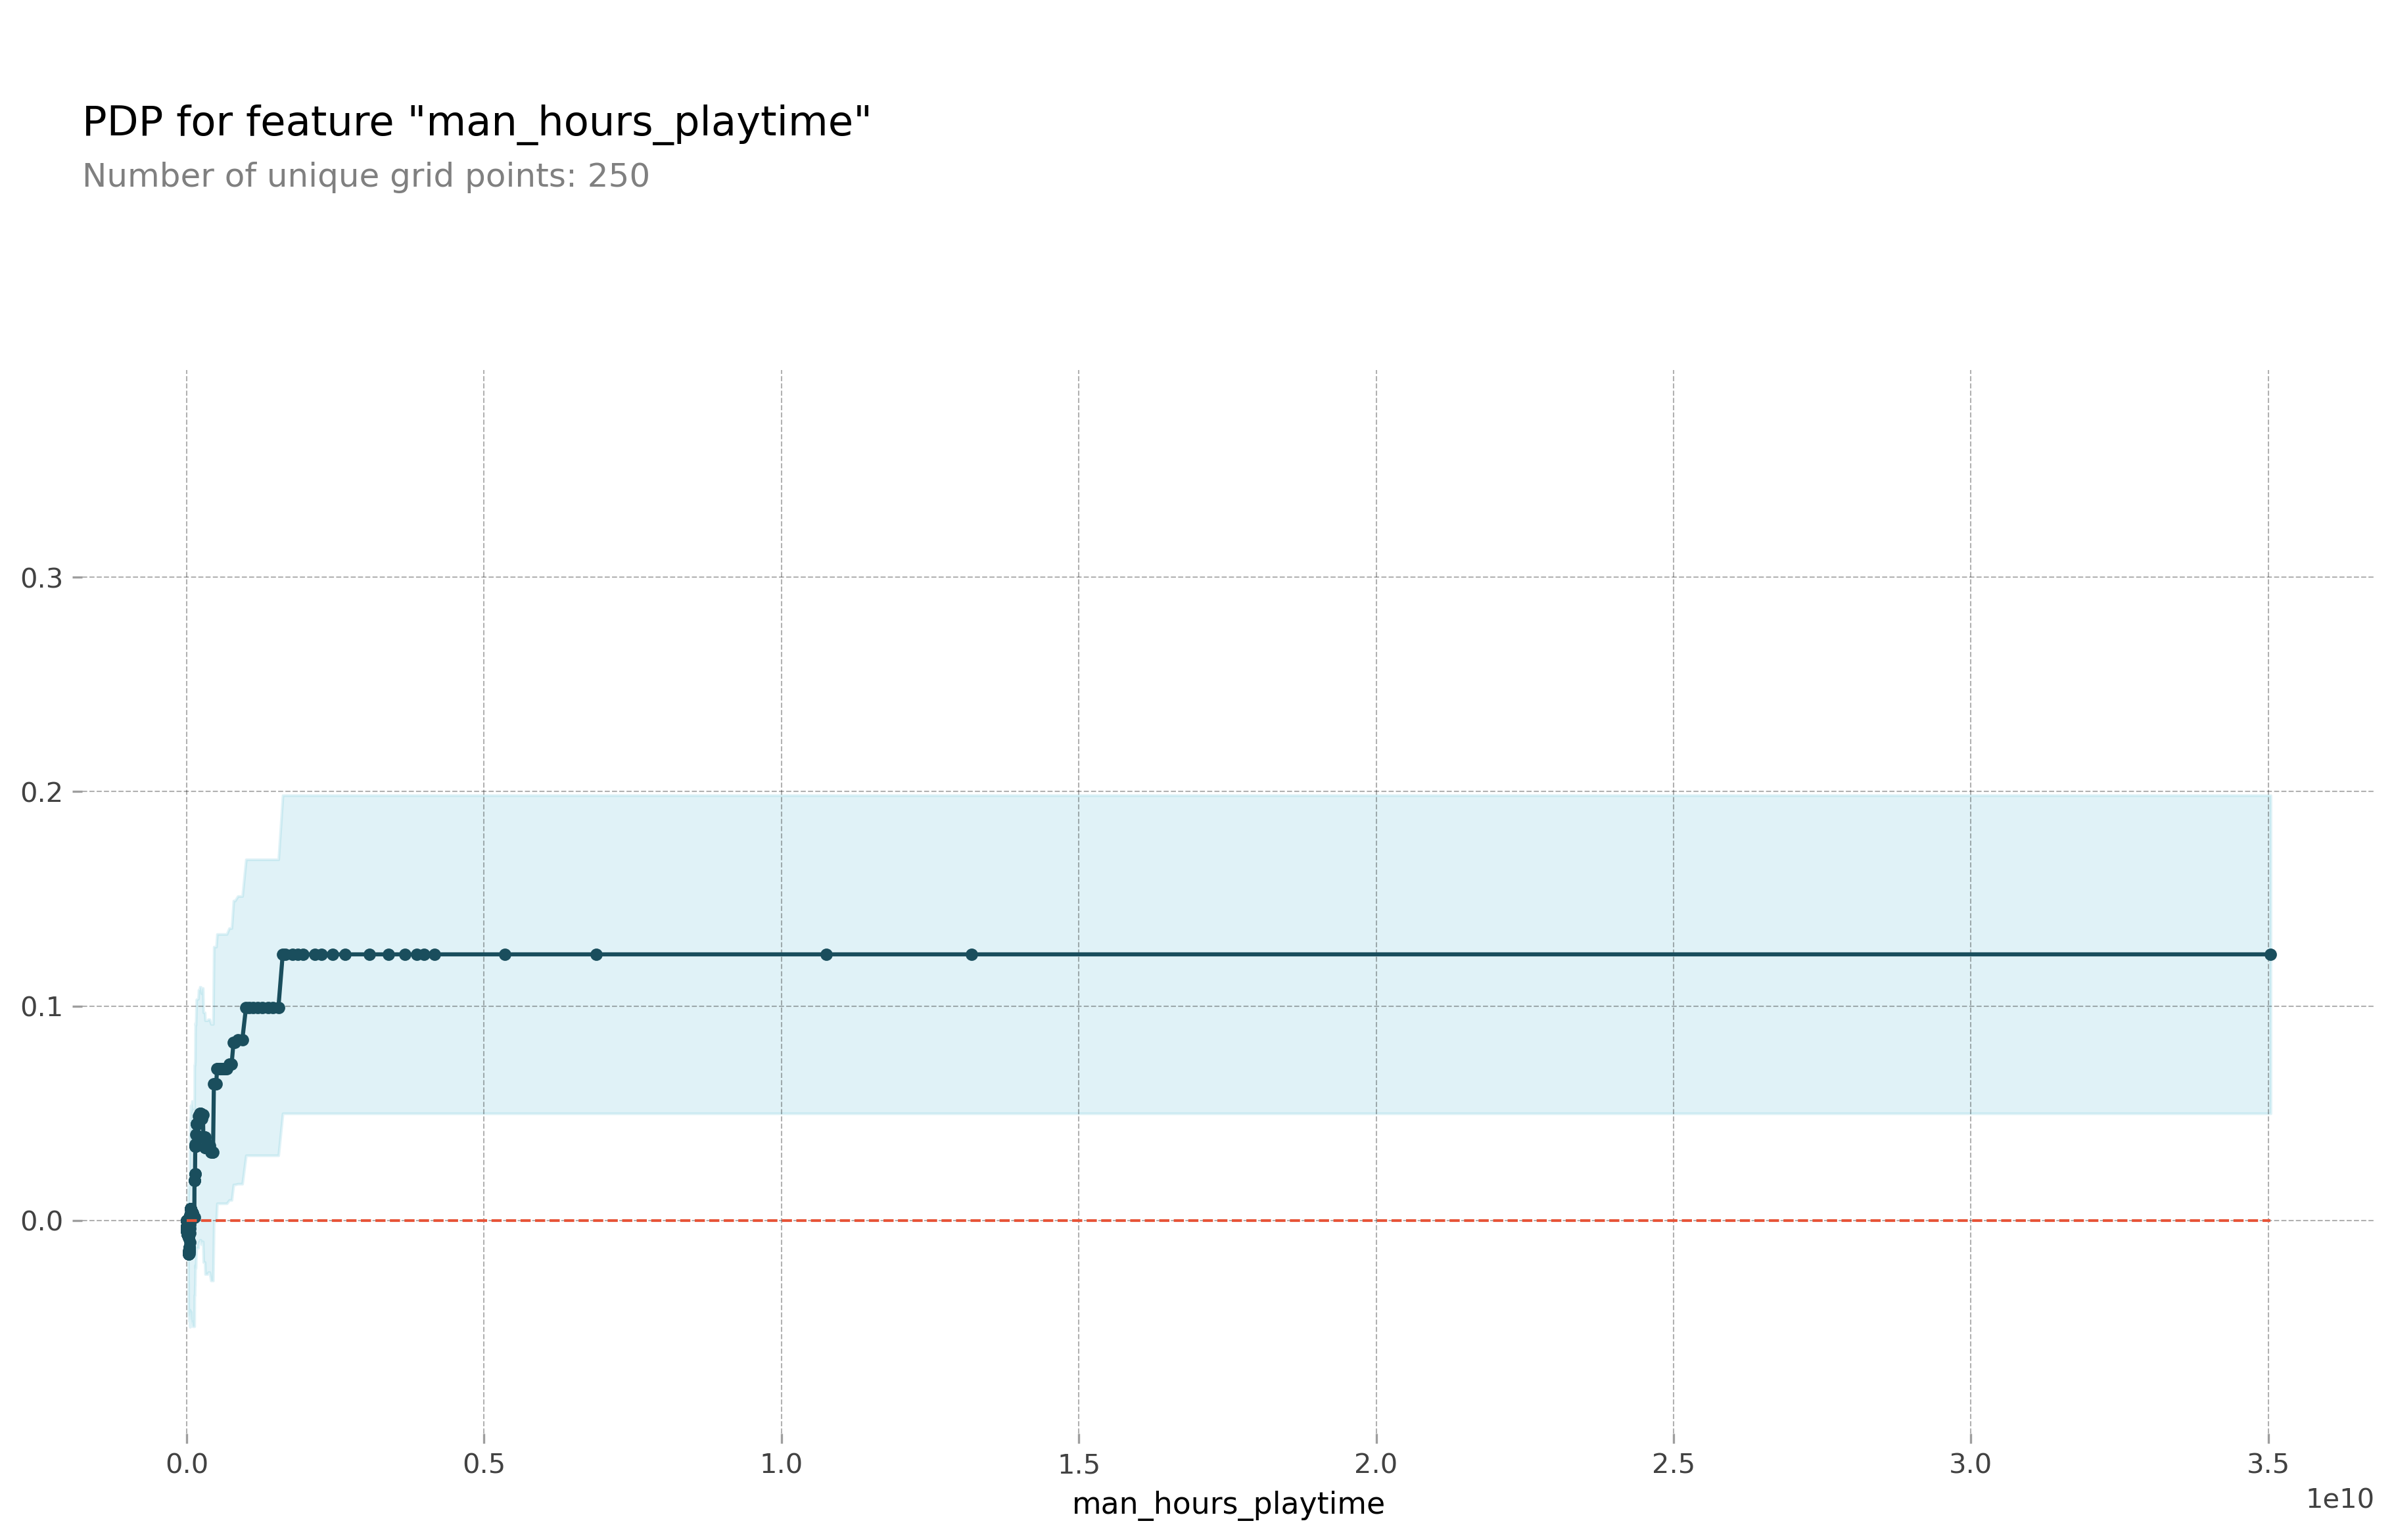

In [261]:
pdp_plot(isolated, feature_name=feature);

(-0.025, 0.15)

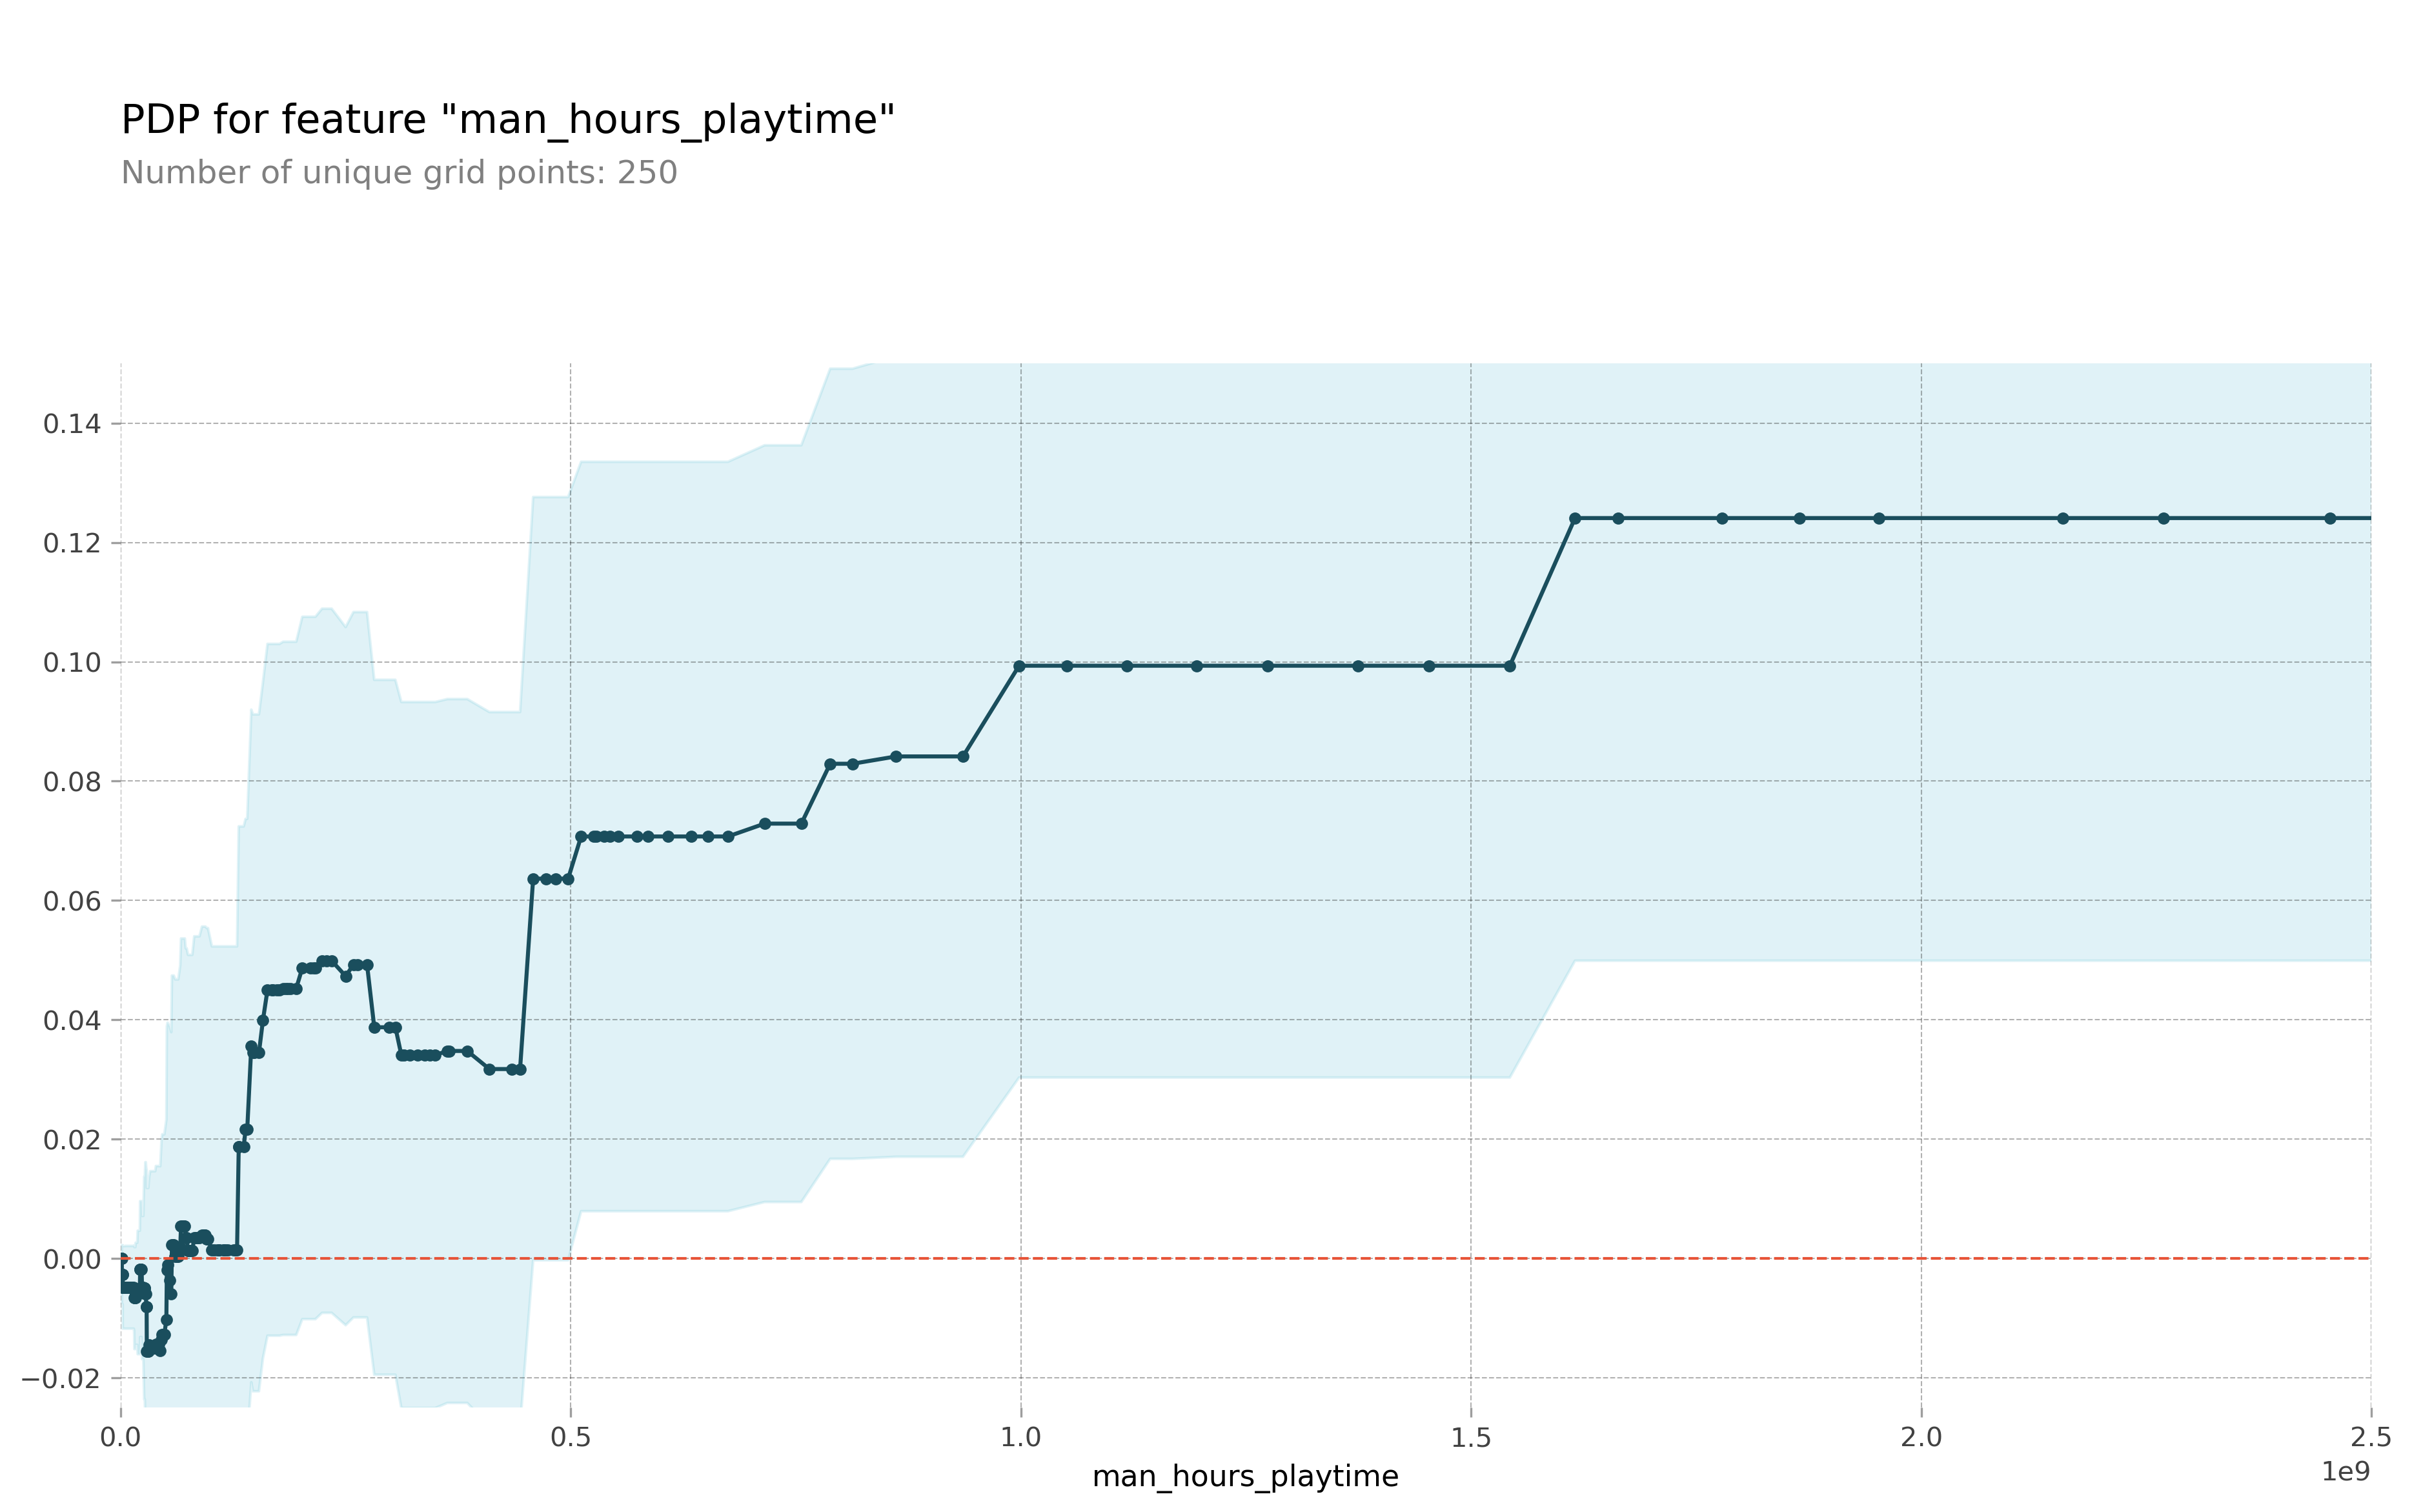

In [269]:
pdp_plot(isolated, feature_name=feature);
plt.xlim([0, 2500000000])
plt.ylim([-0.025, 0.15])

In [149]:
row = test_T.iloc[[11]]

In [150]:
y_test.iloc[[11]]

2934    False
Name: good, dtype: bool

In [151]:
estimator.predict(row)

array([ True])

In [152]:
import shap

In [154]:
explainer = shap.TreeExplainer(estimator)
shap_values = explainer.shap_values(row)
shap_values

[array([[-0.03922439, -0.04032607,  0.        , -0.01420419,  0.06924692,
          0.06099571, -0.10216705,  0.0639958 ,  0.08342539,  0.03104125,
         -0.0487104 ,  0.        , -0.09318168,  0.        ,  0.        ,
          0.        , -0.00496514,  0.        ,  0.        , -0.09209525,
         -0.09207979,  0.        ,  0.04630201,  0.        ,  0.        ,
         -0.05247123,  0.        ,  0.        ,  0.23918422,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.06101168,  0.        ,  0.        , -0.01440676,  0.        ,
          0.        ,  0.        ,  0.        ,  0.03779484,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.09224958,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        , -0.00361506,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        , -0.00880246,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.0347905 ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        , -0.03939934,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        , -0.00744291,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        , -0.07831822,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        , -0.07261885,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
    

In [159]:
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1],
    shap_values=shap_values[1],
    features=row
)

In [162]:
estimator.predict(pd.DataFrame([100000000, 100000000, 5]))

ValueError: Number of features of the model must match the input. Model n_features_ is 346 and input n_features is 1 

In [175]:
shapley_estimator = estimator

In [176]:
small_df = train_T[['man_hours_playtime', 'revenue', 'platform_windows', 'platform_mac', 'platform_linux']]

In [177]:
shapley_estimator.fit(small_df, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=62,
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=119, min_split_gain=0.0, n_estimators=97,
               n_jobs=-1, num_leaves=195, objective=None, random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [245]:
def predict(man_hours, revenue, platform_windows, platform_mac, platform_linux):
    df = pd.DataFrame(
        data = [[man_hours, revenue, platform_windows, platform_mac, platform_linux]],
        columns = ['man_hours', 'revenue', 'platform_windows', 'platform_mac', 'platform_linux']
        )


    pred = shapley_estimator.predict(df)

    explainer = shap.TreeExplainer(shapley_estimator)
    shap_values = explainer.shap_values(df)

    feature_names = df.columns
    feature_values = df.values[0]
    shaps = pd.Series(shap_values[0][0], zip(feature_names, feature_values))

    #result = f'${pred:,.0f} estimated rent for this NYC apartment. \n\n'
    #result += f'Starting from baseline of ${explainer.expected_value} \n'
    #result += shaps.to_string()
    #print(result)

    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value[0], 
        shap_values=shap_values[0], 
        features=df
    )

In [246]:
df = pd.DataFrame(
        data = [[100000000, 10000000000, 1, 0, 1]],
        columns = ['man_hours', 'revenue', 'platform_windows', 'platform_mac', 'platform_linux']
        )
df

,man_hours,revenue,platform_windows,platform_mac,platform_linux
0,100000000,10000000000,1,0,1


In [247]:
shapley_estimator.predict(df)

array([False])

In [248]:
pred = shapley_estimator.predict(df)

explainer = shap.TreeExplainer(shapley_estimator)
shap_values = explainer.shap_values(df)

In [249]:
feature_names = df.columns
feature_values = df.values[0]
shap_values[0]
feature_names
feature_values
zip(feature_names, feature_values)
shaps = pd.Series(shap_values[0][0], zip(feature_names, feature_values))

In [254]:
predict(50000000, 1000, 1, 1, 1)